In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import torch.optim as optim


print("MPS built:", torch.backends.mps.is_built())
print("MPS available:", torch.backends.mps.is_available())

# If available:
device = torch.device("mps")
x = torch.ones(1, device=device)
print(x)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


# load the data stored in 1d_RDE_sim/1d_dataset_hard_dataset:
data_high_fidelity_sim = np.load('1d_RDE_sim/1d_dataset_hard_dataset.npy', allow_pickle=True)

# load the sim from the Koch model:
data_koch_model = np.load('Koch_model/temperature_field.npy')

MPS built: True
MPS available: True
tensor([1.], device='mps:0')


In [75]:
def plot_1d_dataset_as_heatmap(dataset1d, title = ""): 

    plt.figure(figsize=(10, 6))
    plt.imshow(dataset1d.T, aspect='auto', cmap='RdBu_r', origin='lower', vmin = -0.04288087, vmax = 1.0402466)
    plt.colorbar(label='Value')
    plt.xlabel('Time Index')
    plt.ylabel('X Index')
    # plt.title(title, fontdict={'fontsize':20})
    plt.show()
    

Plotting high-fidelity simulation dataset...


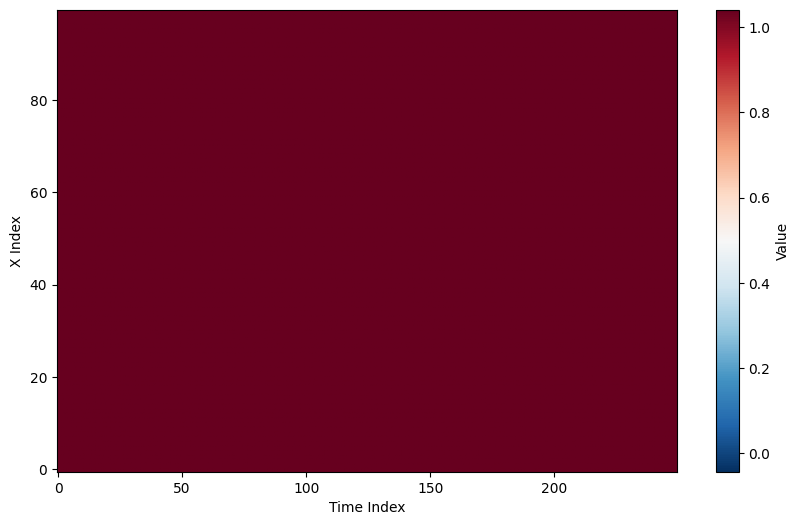

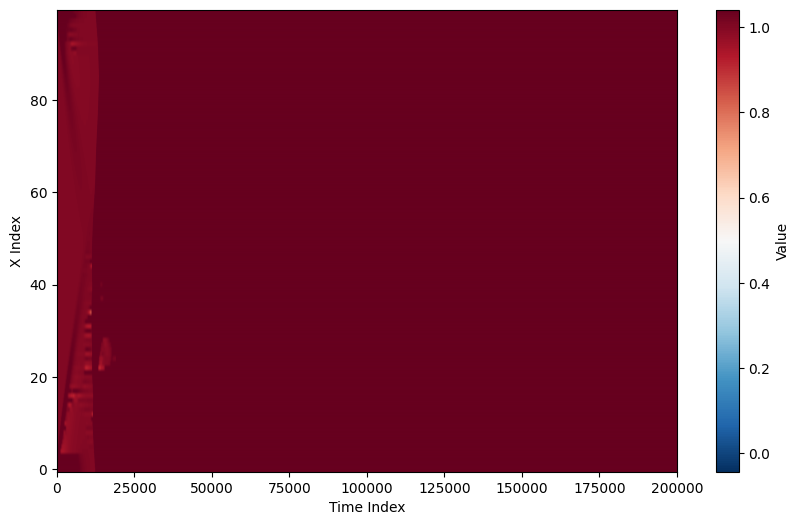

In [76]:
print("Plotting high-fidelity simulation dataset...")
plot_1d_dataset_as_heatmap(data_high_fidelity_sim, title="High-Fidelity Simulation Dataset, canceled rotation")
plot_1d_dataset_as_heatmap(data_koch_model, title="Koch Model Dataset,no preprocessing")

In [77]:
def straighten_data(data, shift_per_row):
    """
    Straighten x-direction rotation over time via row-wise circular *fractional* shifts.

    Args:
        data: array of shape (T, n)
        shift_per_row: scalar (pixels per timestep for every row)

    Returns:
        straightened: array of shape (T, n)
    """
    T, n = data.shape
    
    # FFT along the spatial dimension (axis 1)
    data_fft = np.fft.fft(data, axis=1)
    
    # Wavenumbers (frequencies)
    # fftfreq returns f = k/n corresponding to the frequencies
    freqs = np.fft.fftfreq(n)
    
    # Shifts for each row: shape (T, 1)
    # We assume the shift accumulates linearly with time index
    shifts = (np.arange(T) * shift_per_row).reshape(-1, 1)
    
    # Fourier shift theorem: f(x - d) <-> F(k) * exp(-2*pi*i * f * d)
    # We want to shift by 'shifts'.
    phase_shift = np.exp(-2j * np.pi * freqs[np.newaxis, :] * shifts)
    
    data_shifted_fft = data_fft * phase_shift
    
    data_shifted = np.fft.ifft(data_shifted_fft, axis=1)
    
    return np.real(data_shifted)

def preprocessing_Koch_model(dataset, nx_sim, T_sim):
    
    T, n = dataset.shape
    print(f"Koch model dataset shape: T={T}, n={n}")
    if T > T_sim:
        t_start = 100_000
        t_end   = 110_000
        dataset_cropped = dataset[t_start:t_end, :]
        
        print(f" Cropped Koch model dataset to shape: {dataset_cropped.shape}")
    else:
        dataset_cropped = dataset
        print(" No cropping needed for Koch model dataset.")
        
    T, n = dataset_cropped.shape
    if T > T_sim: 
        # we have to subsample in time
        factor = T // T_sim
        print(f"factor for time subsampling: {factor}")
        dataset_cropped = dataset_cropped[::factor, :]
    
    # cancel out the rotation
    SHIFT_PER_ROW =  -0.27  # pixels per timestep - adjust as needed
    print(f"Applying wave straightening with shift_per_row={SHIFT_PER_ROW}")
    print(" shape of load_X before straightening: ", dataset_cropped.shape)
    Koch_model_straightened = straighten_data(
        dataset_cropped, shift_per_row=SHIFT_PER_ROW
    )

    Koch_model_straightened_minmax = (Koch_model_straightened - np.min(Koch_model_straightened)) / (np.max(Koch_model_straightened) - np.min(Koch_model_straightened))
    return Koch_model_straightened_minmax

def prepropressing_high_fidelity_sim(dataset):
    # normalize to [0, 1]
    print(" min, max of high-fidelity sim before minmax normalization: ", np.min(dataset), np.max(dataset)  )
    dataset_minmax = (dataset - np.min(dataset)) / (np.max(dataset) - np.min(dataset))
    print(" min, max of high-fidelity sim after minmax normalization: ", np.min(dataset_minmax), np.max(dataset_minmax))
    
    return dataset_minmax

T_sim, nx_sim = data_high_fidelity_sim.shape
print(f" High-fidelity sim shape: nx={nx_sim}, T={T_sim}")
print(f"Koch_model shape before processing: {data_koch_model.shape}")
data_koch_model_processed = preprocessing_Koch_model(data_koch_model, nx_sim, T_sim)
data_high_fidelity_sim_processed = prepropressing_high_fidelity_sim(data_high_fidelity_sim)
print(f"Koch_model shape after processing: {data_koch_model_processed.shape}")
# save processed datasets
np.save('DA_data/high_fidelity_sim_processed.npy', data_high_fidelity_sim_processed)
np.save('DA_data/Koch_model_processed.npy', data_koch_model_processed)

 High-fidelity sim shape: nx=100, T=250
Koch_model shape before processing: (200001, 100)
Koch model dataset shape: T=200001, n=100
 Cropped Koch model dataset to shape: (10000, 100)
factor for time subsampling: 40
Applying wave straightening with shift_per_row=-0.27
 shape of load_X before straightening:  (250, 100)
 min, max of high-fidelity sim before minmax normalization:  1932.9085327581226 3593.979156809994
 min, max of high-fidelity sim after minmax normalization:  0.0 1.0
Koch_model shape after processing: (250, 100)


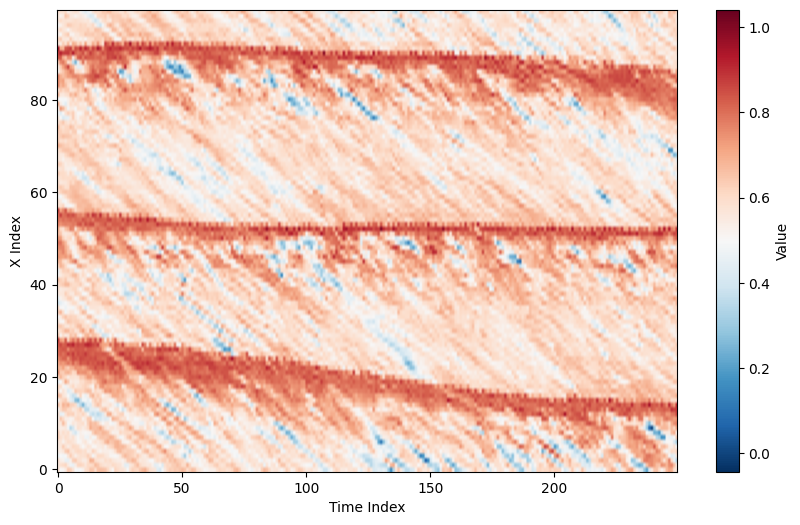

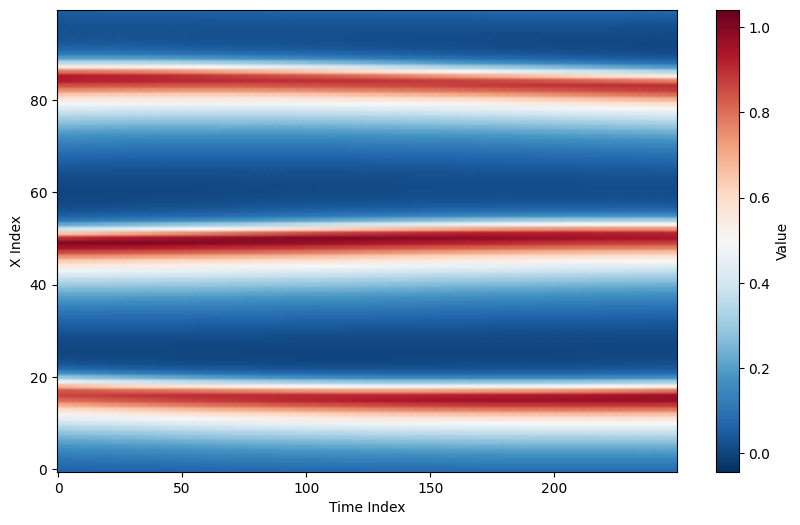

In [78]:
plot_1d_dataset_as_heatmap(data_high_fidelity_sim_processed, title="High-Fidelity Simulation Dataset, canceled rotation")
plot_1d_dataset_as_heatmap(data_koch_model_processed, title="Koch Model Data, COM reference, normalized")

In [79]:
class SHRED(nn.Module):
    """Standard SHRED encoder-decoder"""

    def __init__(self, num_sensors, lags, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(num_sensors, hidden_size, num_layers=2,
                            batch_first=True, dropout=0.1)
        self.norm = nn.LayerNorm(hidden_size)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def encode(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.norm(h_n[-1])

    def forward(self, x):
        z = self.encode(x)
        return self.decoder(z), z
    
class TimeSeriesDataset(Dataset):
    def __init__(self, U, sensor_indices, lags, scaler=None, fit_scaler=False):
        self.U = U
        self.sensor_indices = sensor_indices
        self.lags = lags
        self.S = U[:, sensor_indices]
        print(f" shape of sensors : {self.S.shape} (should be T x num_sensors) ")
        if scaler is None:
            self.scaler_U = MinMaxScaler()
            self.scaler_S = MinMaxScaler()
        else:
            self.scaler_U, self.scaler_S = scaler

        if fit_scaler:
            self.U_scaled = self.scaler_U.fit_transform(self.U)
            self.S_scaled = self.scaler_S.fit_transform(self.S)
        else:
            self.U_scaled = self.scaler_U.transform(self.U)
            self.S_scaled = self.scaler_S.transform(self.S)

        self.valid_indices = np.arange(lags, len(U))

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        t = self.valid_indices[idx]
        if self.lags > 0:
            sensor_history = self.S_scaled[t - self.lags:t]
            # if t < self.lags:
            #     # pad with zeros if not enough history
            #     print(" padding applied ")
            #     padding = np.zeros((self.lags - t, len(self.sensor_indices)))
            #     sensor_history = np.vstack((padding, sensor_history))
        else:
            sensor_history = self.S_scaled[t]
        full_state = self.U_scaled[t]
        return (torch.tensor(sensor_history, dtype=torch.float32),
                torch.tensor(full_state, dtype=torch.float32))

    def get_scalers(self):
        return (self.scaler_U, self.scaler_S)
    
    # Training Functions
def train_simple_shred(model, train_loader, epochs=200, lr=1e-3):
    print("\n=== training SHRED ===")
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for sensors, targets in train_loader:
            sensors, targets = sensors.to(device), targets.to(device)
            optimizer.zero_grad()
            pred, _ = model(sensors)
            loss = F.mse_loss(pred, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 50 == 0:
            print(f"  Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.6f}")
    return model

In [80]:
def inspect_model_predictions(ground_truth, all_preds, title_prefix=""):
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        
    # Plot predictions
    im1 = axes[0].imshow(all_preds.T, aspect='auto', cmap='RdBu_r', origin='lower', vmin = -0.04288087, vmax = 1.0402466) 
                         # extent=(0, all_preds.shape[0], 0, all_preds.shape[1]))
    axes[0].set_xlabel('Time Index')
    axes[0].set_ylabel('X Index')
    axes[0].set_title(f"{title_prefix} Predictions on High-Fidelity Data", fontdict={'fontsize':16})
    plt.colorbar(im1, ax=axes[0], label='Value')

    # Plot error
    error = np.abs(all_preds - ground_truth)
    im2 = axes[1].imshow(error.T, aspect='auto', cmap='inferno', origin='lower', 
                            vmin=0, vmax=0.75)
    axes[1].set_xlabel('Time Index')
    axes[1].set_ylabel('X Index')
    axes[1].set_title(f"{title_prefix} Absolute Error on High-Fidelity Data", fontdict={'fontsize':16})
    plt.colorbar(im2, ax=axes[1], label='Value')

    plt.tight_layout()
    plt.show()
    


# Model 1: train SHRED on high-fidelity only

In [102]:
data_model_1 = data_high_fidelity_sim_processed

print("shape of data_model_1 : ", data_model_1.shape)
M, N = data_model_1.shape


shape of data_model_1 :  (250, 100)


In [ ]:
num_sensors = int(25)
lags = 5
hidden_size = 32

sensor_indices = np.linspace(0, N - 1, num_sensors, dtype=int)
temp_dataset = TimeSeriesDataset(data_model_1, sensor_indices, lags, fit_scaler=True)


 shape of sensors : (250, 25) (should be T x num_sensors) 


In [104]:
# Account for lags when splitting
n_train = int(0.8 * M)

combined_scaler = temp_dataset.get_scalers()
scaler_U, _ = combined_scaler

# Split the raw data - no overlap needed, padding will handle it
zeros_padding = np.zeros((lags, N))
train_data = data_model_1[:n_train]
train_data = np.vstack((zeros_padding, train_data))  # pad the beginning
valid_data = data_model_1[n_train - lags:]

# Create train and validation datasets with the same scaler
train_high_fidelity = TimeSeriesDataset(train_data, sensor_indices, lags, scaler=combined_scaler, fit_scaler=False)
valid_high_fidelity = TimeSeriesDataset(valid_data, sensor_indices, lags, scaler=combined_scaler, fit_scaler=False)

# Create data loaders
train_loader_model1 = DataLoader(train_high_fidelity, batch_size=32, shuffle=True)
valid_loader_model1 = DataLoader(valid_high_fidelity, batch_size=32)

print(f"    Train samples (high_fidelity): {len(train_high_fidelity)}")
print(f"    Valid samples (high_fidelity): {len(valid_high_fidelity)}")

# Initialize model
model_1_shred = SHRED(num_sensors, lags, hidden_size, N).to(device)

print("\n Training SHRED model...")
model_1_shred = train_simple_shred(model_1_shred, train_loader_model1, epochs=500, lr=1e-3)

# Evaluate
model_1_shred.eval()
with torch.no_grad():
    preds, targets_list = [], []
    for sensors, targets in valid_loader_model1:
        pred, _ = model_1_shred(sensors.to(device))
        preds.append(pred.cpu())
        targets_list.append(targets)
    preds = scaler_U.inverse_transform(torch.cat(preds).numpy())
    targets_np = scaler_U.inverse_transform(torch.cat(targets_list).numpy())
    baseline_rmse = np.sqrt(np.mean((preds - targets_np) ** 2))
print(f"   Model 1 baseline RMSE: {baseline_rmse:.6f}")

# Inference on training data for visualization
with torch.no_grad():
    train_preds, targets_list = [], []
    for sensors, targets in train_loader_model1:
        pred, _ = model_1_shred(sensors.to(device))
        train_preds.append(pred.cpu())
        targets_list.append(targets)
    train_preds = scaler_U.inverse_transform(torch.cat(train_preds).numpy())
    targets_np = scaler_U.inverse_transform(torch.cat(targets_list).numpy())
    baseline_rmse = np.sqrt(np.mean((train_preds - targets_np) ** 2))


 shape of sensors : (225, 25) (should be T x num_sensors) 
 shape of sensors : (75, 25) (should be T x num_sensors) 
    Train samples (high_fidelity): 200
    Valid samples (high_fidelity): 50

 Training SHRED model...

=== training SHRED ===
  Epoch 50/500, Loss: 0.020475
  Epoch 100/500, Loss: 0.015466
  Epoch 150/500, Loss: 0.011882
  Epoch 200/500, Loss: 0.009618
  Epoch 250/500, Loss: 0.008439
  Epoch 300/500, Loss: 0.007343
  Epoch 350/500, Loss: 0.006471
  Epoch 400/500, Loss: 0.006220
  Epoch 450/500, Loss: 0.005661
  Epoch 500/500, Loss: 0.005045
   Model 1 baseline RMSE: 0.113587


train preds shape:  (200, 100)  preds shape:  (50, 100)


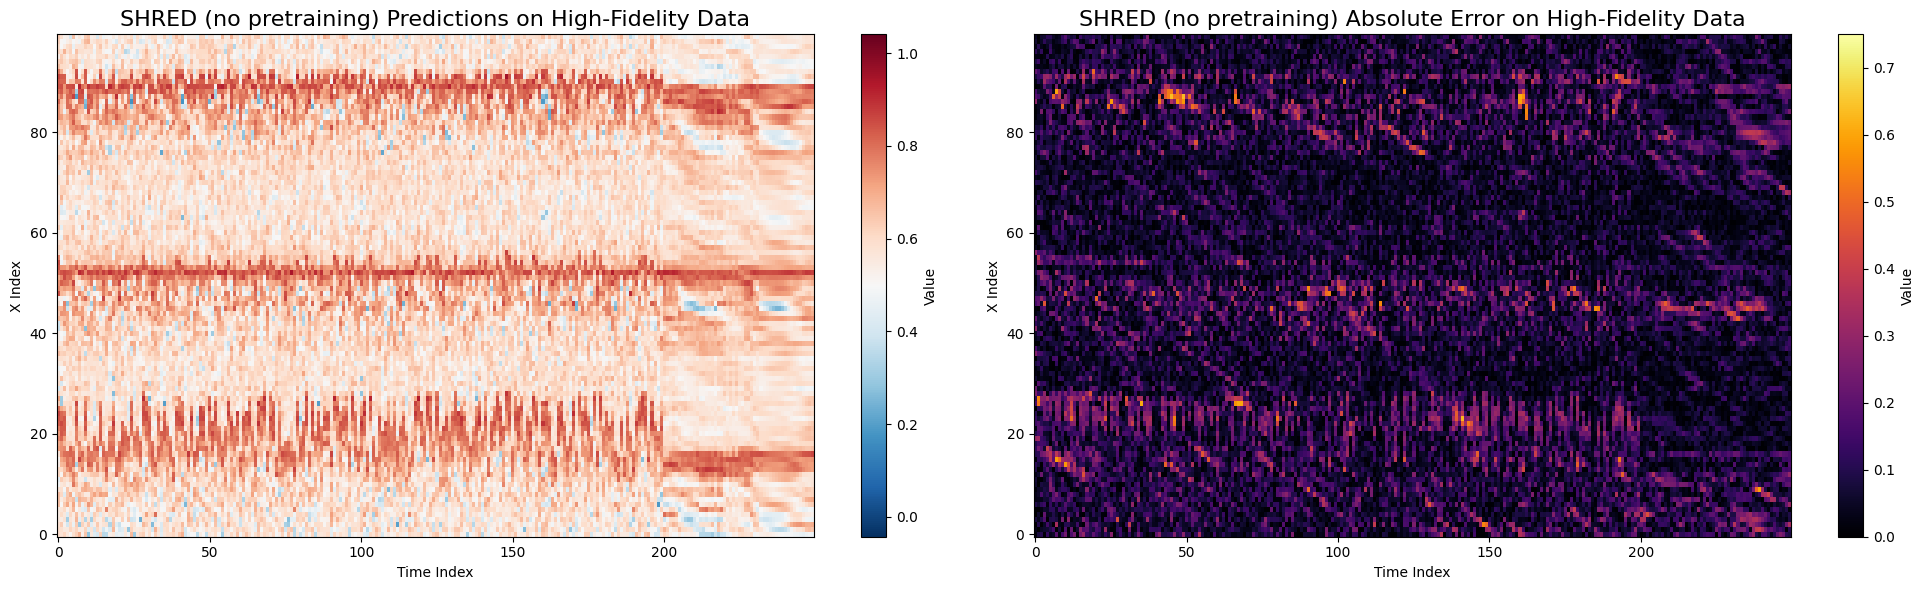

In [105]:
print("train preds shape: ", train_preds.shape, " preds shape: ", preds.shape)
all_preds = np.concatenate([train_preds, preds], axis=0)
inspect_model_predictions(data_model_1, all_preds, "SHRED (no pretraining)")

In [106]:
from skimage.metrics import structural_similarity as ssim

data_range = data_model_1.max() - data_model_1.min()

ssim_val = ssim(data_model_1, all_preds, data_range=data_range)
print(f"SSIM between SHRED (no pre) predictions and high-fidelity data: {ssim_val:.6f}")



SSIM between SHRED (no pre) predictions and high-fidelity data: 0.177233


## bigger SHRED model: 

In [107]:
# num_sensors = int(25)
# lags = 5
# hidden_size = 100

# sensor_indices = np.linspace(0, N - 1, num_sensors, dtype=int)
# temp_dataset = TimeSeriesDataset(data_model_1, sensor_indices, lags, fit_scaler=True)


In [108]:
# n_train = int(0.8 * M)

# # IMPORTANT: Fit scaler on combined data to handle different scales
# # temp_dataset already exists from CELL INDEX 8, so we can use it directly
# combined_scaler = temp_dataset.get_scalers()
# scaler_U, _ = combined_scaler

# # Split the raw data - no overlap needed, padding will handle it
# zeros_padding = np.zeros((lags, N))
# train_data = data_model_1[:n_train]
# train_data = np.vstack((zeros_padding, train_data))  # pad the beginning
# valid_data = data_model_1[n_train - lags:]

# # Create train and validation datasets with the same scaler
# train_high_fidelity = TimeSeriesDataset(train_data, sensor_indices, lags, scaler=combined_scaler, fit_scaler=False)
# valid_high_fidelity = TimeSeriesDataset(valid_data, sensor_indices, lags, scaler=combined_scaler, fit_scaler=False)

# # Create data loaders
# train_loader_model1 = DataLoader(train_high_fidelity, batch_size=32, shuffle=True)
# valid_loader_model1 = DataLoader(valid_high_fidelity, batch_size=32)

# print(f"    Train samples (high_fidelity): {len(train_high_fidelity)}")
# print(f"    Valid samples (high_fidelity): {len(valid_high_fidelity)}")

# # Initialize model
# model_1_shred = SHRED(num_sensors, lags, hidden_size, N).to(device)

# # Note: You need to define the train_model_1_shred function
# # For now, here's a basic training loop structure:
# print("\n Training SHRED model...")
# model_1_shred = train_simple_shred(model_1_shred, train_loader_model1, epochs=500, lr=1e-3)

#     # Evaluate LF-SHRED baseline
# model_1_shred.eval()
# with torch.no_grad():
#     preds, targets_list = [], []
#     for sensors, targets in valid_loader_model1:
#         pred, _ = model_1_shred(sensors.to(device))
#         preds.append(pred.cpu())
#         targets_list.append(targets)
#     preds = scaler_U.inverse_transform(torch.cat(preds).numpy())
#     targets_np = scaler_U.inverse_transform(torch.cat(targets_list).numpy())
#     baseline_rmse = np.sqrt(np.mean((preds - targets_np) ** 2))
# print(f"   Model 1 (much bigger) baseline RMSE: {baseline_rmse:.6f}")

# Model 2: MLP 

In [109]:
class MLP(nn.Module):
    """Standard SHRED encoder-decoder"""

    def __init__(self, num_sensors, lags, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        # self.lstm = nn.LSTM(num_sensors, hidden_size, num_layers=2,
        #                     batch_first=True, dropout=0.1)
        
        self.norm = nn.LayerNorm(hidden_size)
        self.decoder = nn.Sequential(
            nn.Linear(num_sensors, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def encode(self, x):
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decoder(z), z

In [110]:
num_sensors = int(25)
lags = 0
hidden_size = 32

sensor_indices = np.linspace(0, N - 1, num_sensors, dtype=int)
temp_dataset = TimeSeriesDataset(data_model_1, sensor_indices, lags, fit_scaler=True)


 shape of sensors : (250, 25) (should be T x num_sensors) 


In [111]:
n_train = int(0.8 * M)

# IMPORTANT: Fit scaler on combined data to handle different scales
# temp_dataset already exists from CELL INDEX 8, so we can use it directly
combined_scaler = temp_dataset.get_scalers()
scaler_U, _ = combined_scaler

# Split the raw data, not the dataset
train_data = data_model_1[:n_train]
valid_data = data_model_1[n_train:]

# Create train and validation datasets with the same scaler
train_high_fidelity = TimeSeriesDataset(train_data, sensor_indices, lags, scaler=combined_scaler, fit_scaler=False)
valid_high_fidelity = TimeSeriesDataset(valid_data, sensor_indices, lags, scaler=combined_scaler, fit_scaler=False)

# Create data loaders
train_loader_model2 = DataLoader(train_high_fidelity, batch_size=32, shuffle=True)
valid_loader_model2 = DataLoader(valid_high_fidelity, batch_size=32)

print(f"    Train samples (high_fidelity): {len(train_high_fidelity)}")
print(f"    Valid samples (high_fidelity): {len(valid_high_fidelity)}")

# Initialize model
model_2_MLP = MLP(num_sensors, lags, hidden_size, N).to(device)

# Note: You need to define the train_model_2_MLP function
# For now, here's a basic training loop structure:
print("\n Training MLP model...")
model_2_MLP = train_simple_shred(model_2_MLP, train_loader_model2, epochs=500, lr=1e-3)

    # Evaluate LF-SHRED baseline
model_2_MLP.eval()
with torch.no_grad():
    preds, targets_list = [], []
    for sensors, targets in valid_loader_model2:
        pred, _ = model_2_MLP(sensors.to(device))
        preds.append(pred.cpu())
        targets_list.append(targets)
    preds = scaler_U.inverse_transform(torch.cat(preds).numpy())
    targets_np = scaler_U.inverse_transform(torch.cat(targets_list).numpy())
    baseline_rmse = np.sqrt(np.mean((preds - targets_np) ** 2))
    
print(f"   Model 2 - MLP -  baseline RMSE: {baseline_rmse:.6f}")

with torch.no_grad():
    train_preds, targets_list = [], []
    for sensors, targets in train_loader_model2:
        pred, _ = model_2_MLP(sensors.to(device))
        train_preds.append(pred.cpu())
        targets_list.append(targets)
    train_preds = scaler_U.inverse_transform(torch.cat(train_preds).numpy())
    targets_np = scaler_U.inverse_transform(torch.cat(targets_list).numpy())
    baseline_rmse = np.sqrt(np.mean((train_preds - targets_np) ** 2))
    
# print(preds.shape, train_preds.shape)   

# all_preds = np.concatenate([train_preds, preds], axis=0)
# plot_1d_dataset_as_heatmap(all_preds, title="SHRED Predictions on High-Fidelity Data")

 shape of sensors : (200, 25) (should be T x num_sensors) 
 shape of sensors : (50, 25) (should be T x num_sensors) 
    Train samples (high_fidelity): 200
    Valid samples (high_fidelity): 50

 Training MLP model...

=== training SHRED ===
  Epoch 50/500, Loss: 0.020867
  Epoch 100/500, Loss: 0.016771
  Epoch 150/500, Loss: 0.014705
  Epoch 200/500, Loss: 0.013465
  Epoch 250/500, Loss: 0.012663
  Epoch 300/500, Loss: 0.012112
  Epoch 350/500, Loss: 0.010944
  Epoch 400/500, Loss: 0.010416
  Epoch 450/500, Loss: 0.009931
  Epoch 500/500, Loss: 0.009316
   Model 2 - MLP -  baseline RMSE: 0.095795


In [112]:
with torch.no_grad():
    train_preds, targets_list = [], []
    for sensors, targets in train_loader_model2:
        pred, _ = model_2_MLP(sensors.to(device))
        train_preds.append(pred.cpu())
        targets_list.append(targets)
    train_preds = scaler_U.inverse_transform(torch.cat(train_preds).numpy())
    targets_np = scaler_U.inverse_transform(torch.cat(targets_list).numpy())
    baseline_rmse = np.sqrt(np.mean((train_preds - targets_np) ** 2))
    
print(preds.shape, train_preds.shape)   

# all_preds = np.concatenate([train_preds, preds], axis=0)
# plot_1d_dataset_as_heatmap(all_preds, title="SHRED Predictions on High-Fidelity Data")

(50, 100) (200, 100)


train preds shape:  (200, 100)  preds shape:  (50, 100)


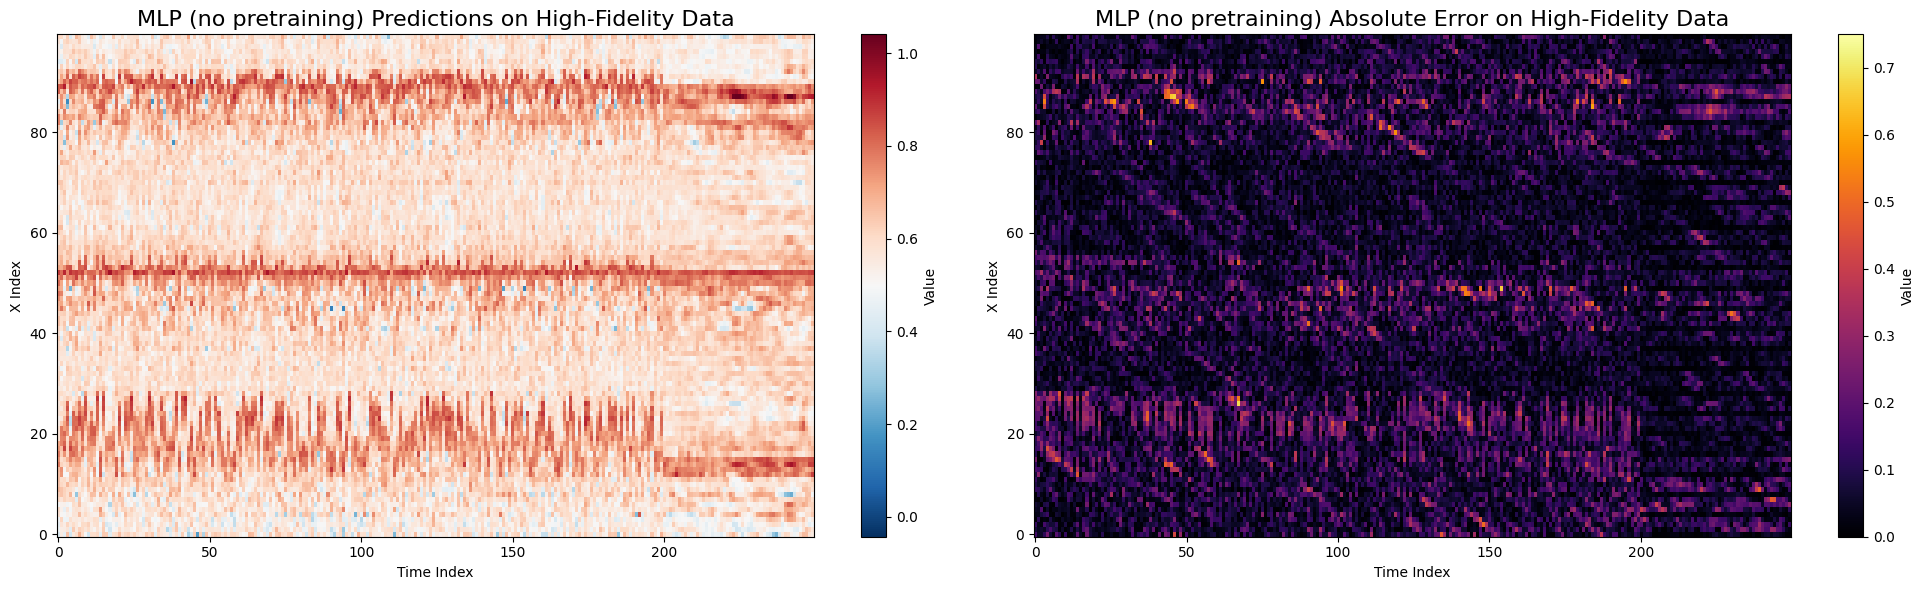

In [113]:
print("train preds shape: ", train_preds.shape, " preds shape: ", preds.shape)
all_preds = np.concatenate([train_preds, preds], axis=0)
inspect_model_predictions(data_model_1, all_preds, "MLP (no pretraining)")

In [114]:
data_range = data_model_1.max() - data_model_1.min()

ssim_val = ssim(data_model_1, all_preds, data_range=data_range)
print(f"SSIM between MLP (no pre) predictions and high-fidelity data: {ssim_val:.6f}")



SSIM between MLP (no pre) predictions and high-fidelity data: 0.232390


# Model 3: pretrained on Koch's model and fine-tuned on the high fidelity dataset.

In [ ]:
num_sensors = int(25)
lags = 5
hidden_size = 32

foundational_data3 = data_koch_model_processed
high_fidelity_data_3 = data_high_fidelity_sim_processed
M, N = foundational_data3.shape


sensor_indices = np.linspace(0, N - 1, num_sensors, dtype=int)
temp_dataset = TimeSeriesDataset(high_fidelity_data_3, sensor_indices, lags, fit_scaler=True)



 shape of sensors : (250, 25) (should be T x num_sensors) 


In [117]:
n_fine_tune = int(0.8 * M)

# IMPORTANT: Fit scaler on combined data to handle different scales
# temp_dataset already exists from CELL INDEX 8, so we can use it directly
combined_scaler = temp_dataset.get_scalers()
scaler_U, _ = combined_scaler

# Split the raw data, not the dataset
zeros_padding = np.zeros((lags, N))
pretrain_data = foundational_data3
pretrain_data = np.vstack((zeros_padding, pretrain_data))  # pad the beginning
fine_tune_data = high_fidelity_data_3[:n_fine_tune]
fine_tune_data = np.vstack((zeros_padding, fine_tune_data))  # pad the beginning
valid_data = high_fidelity_data_3[n_fine_tune - lags:]


# Create train and validation datasets with the same scaler
train_pretrainTS = TimeSeriesDataset(pretrain_data, sensor_indices, lags, scaler=combined_scaler, fit_scaler=False)
train_high_fidelity = TimeSeriesDataset(fine_tune_data, sensor_indices, lags, scaler=combined_scaler, fit_scaler=False)
valid_high_fidelity = TimeSeriesDataset(valid_data, sensor_indices, lags, scaler=combined_scaler, fit_scaler=False)

# Create data loaders
train_pretrain_loader = DataLoader(train_pretrainTS, batch_size=32, shuffle=True)
train_loader_model3 = DataLoader(train_high_fidelity, batch_size=32, shuffle=True)
valid_loader_model3 = DataLoader(valid_high_fidelity, batch_size=32)

print(f"    Train samples (high_fidelity): {len(train_high_fidelity)}")
print(f"    Valid samples (high_fidelity): {len(valid_high_fidelity)}")

# Initialize model
model_3_SHRED = SHRED(num_sensors, lags, hidden_size, N).to(device)

# Note: You need to define the train_model_2_MLP function
# For now, here's a basic training loop structure:
print("\n Pretraining  SHRED model...")
model_3_SHRED = train_simple_shred(model_3_SHRED, train_pretrain_loader, epochs=500, lr=1e-3)
print("\n Fine-tuning SHRED model...")
model_3_SHRED = train_simple_shred(model_3_SHRED, train_loader_model3, epochs=300, lr=1e-3)

# Evaluate 
model_3_SHRED.eval()
with torch.no_grad():
    preds, targets_list = [], []
    for sensors, targets in valid_loader_model3:
        pred, _ = model_3_SHRED(sensors.to(device))
        preds.append(pred.cpu())
        targets_list.append(targets)
    preds = scaler_U.inverse_transform(torch.cat(preds).numpy())
    targets_np = scaler_U.inverse_transform(torch.cat(targets_list).numpy())
    baseline_rmse = np.sqrt(np.mean((preds - targets_np) ** 2))
print(f"   Model 3 (pretrained) baseline RMSE: {baseline_rmse:.6f}")
with torch.no_grad():
    train_preds, targets_list = [], []
    for sensors, targets in train_loader_model3:
        pred, _ = model_3_SHRED(sensors.to(device))
        train_preds.append(pred.cpu())
        targets_list.append(targets)
    train_preds = scaler_U.inverse_transform(torch.cat(train_preds).numpy())
    targets_np = scaler_U.inverse_transform(torch.cat(targets_list).numpy())
    baseline_rmse = np.sqrt(np.mean((train_preds - targets_np) ** 2))
    
print(preds.shape, train_preds.shape)   



 shape of sensors : (275, 25) (should be T x num_sensors) 
 shape of sensors : (225, 25) (should be T x num_sensors) 
 shape of sensors : (75, 25) (should be T x num_sensors) 
    Train samples (high_fidelity): 200
    Valid samples (high_fidelity): 50

 Pretraining  SHRED model...

=== training SHRED ===
  Epoch 50/500, Loss: 0.000124
  Epoch 100/500, Loss: 0.000082
  Epoch 150/500, Loss: 0.000043
  Epoch 200/500, Loss: 0.000027
  Epoch 250/500, Loss: 0.000025
  Epoch 300/500, Loss: 0.000023
  Epoch 350/500, Loss: 0.000025
  Epoch 400/500, Loss: 0.000024
  Epoch 450/500, Loss: 0.000022
  Epoch 500/500, Loss: 0.000022

 Fine-tuning SHRED model...

=== training SHRED ===
  Epoch 50/300, Loss: 0.022518
  Epoch 100/300, Loss: 0.017404
  Epoch 150/300, Loss: 0.013589
  Epoch 200/300, Loss: 0.010813
  Epoch 250/300, Loss: 0.008982
  Epoch 300/300, Loss: 0.007626
   Model 3 (pretrained) baseline RMSE: 0.112682
(50, 100) (200, 100)


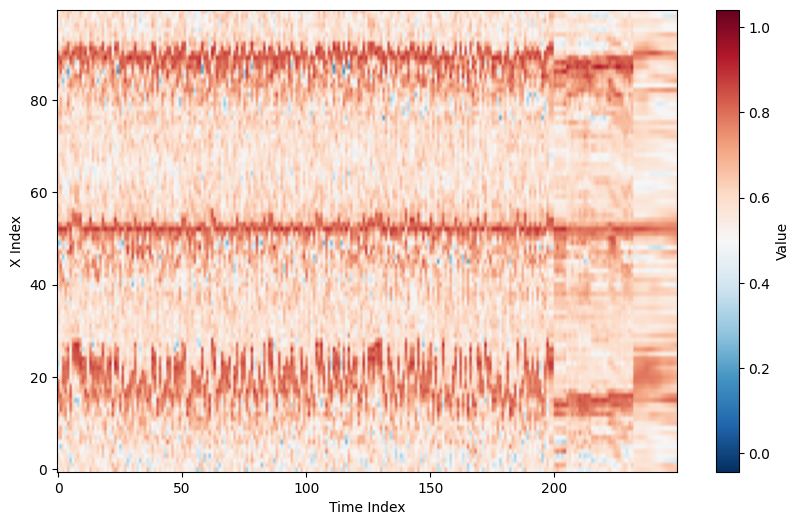

train preds shape:  (200, 100)  preds shape:  (50, 100)


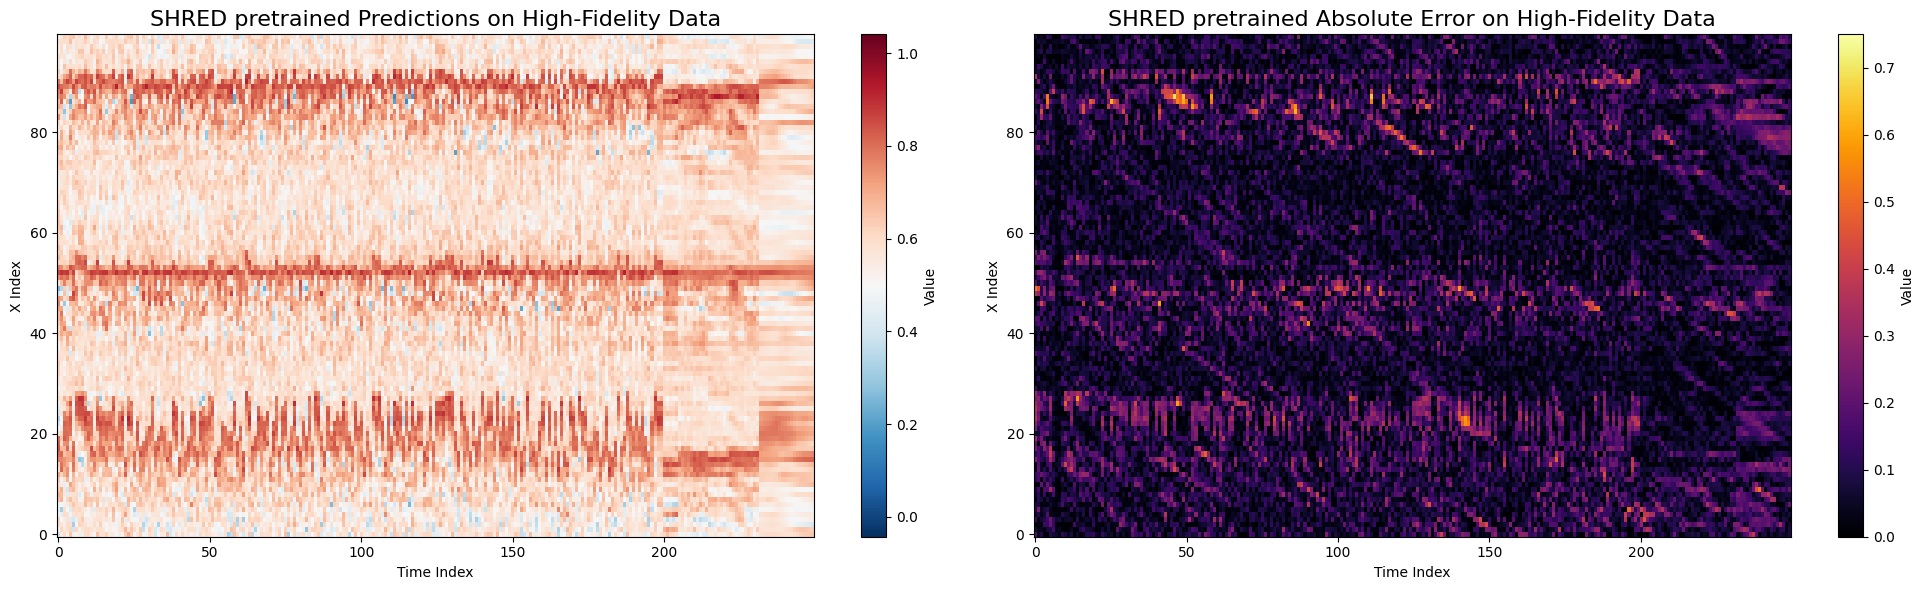

In [118]:
all_preds = np.concatenate([train_preds, preds], axis=0)
plot_1d_dataset_as_heatmap(all_preds, title="SHRED Predictions on High-Fidelity Data")
print("train preds shape: ", train_preds.shape, " preds shape: ", preds.shape)

all_preds = np.concatenate([train_preds, preds], axis=0)
inspect_model_predictions(data_model_1, all_preds, "SHRED pretrained")

In [119]:
data_range = data_model_1.max() - data_model_1.min()

ssim_val = ssim(data_model_1, all_preds, data_range=data_range)
print(f"SSIM between SHRED  (pretrained) predictions and high-fidelity data: {ssim_val:.6f}")



SSIM between SHRED  (pretrained) predictions and high-fidelity data: 0.182204


# Model4 : Pretrained MLP

In [98]:
num_sensors = int(25)
lags = 0
hidden_size = 100

foundational_data4 = data_koch_model_processed
high_fidelity_data_4 = data_high_fidelity_sim_processed
M, N = foundational_data4.shape


sensor_indices = np.linspace(0, N - 1, num_sensors, dtype=int)
temp_dataset = TimeSeriesDataset(high_fidelity_data_4, sensor_indices, lags, fit_scaler=True)

 shape of sensors : (250, 25) (should be T x num_sensors) 


In [99]:
n_fine_tune = int(0.8 * M)

# IMPORTANT: Fit scaler on combined data to handle different scales
# temp_dataset already exists from CELL INDEX 8, so we can use it directly
combined_scaler = temp_dataset.get_scalers()
scaler_U, _ = combined_scaler

# Split the raw data, not the dataset
pretrain_data = foundational_data4
fine_tune_data = high_fidelity_data_4[:n_fine_tune]
valid_data = high_fidelity_data_4[n_fine_tune:]

# Create train and validation datasets with the same scaler
train_pretrainTS_MLP = TimeSeriesDataset(pretrain_data, sensor_indices, lags, scaler=combined_scaler, fit_scaler=False)
train_high_fidelity_MLP = TimeSeriesDataset(fine_tune_data, sensor_indices, lags, scaler=combined_scaler, fit_scaler=False)
valid_high_fidelity_MLP = TimeSeriesDataset(valid_data, sensor_indices, lags, scaler=combined_scaler, fit_scaler=False)

# Create data loaders
train_pretrain_loader = DataLoader(train_pretrainTS_MLP, batch_size=32, shuffle=True)
train_loader_model4 = DataLoader(train_high_fidelity_MLP, batch_size=32, shuffle=True)
valid_loader_model4 = DataLoader(valid_high_fidelity_MLP, batch_size=32)

print(f"    Train samples (high_fidelity): {len(train_high_fidelity_MLP)}")
print(f"    Valid samples (high_fidelity): {len(valid_high_fidelity_MLP)}")

# Initialize model
model_4_MLP = MLP(num_sensors, lags, hidden_size, N).to(device)

# Note: You need to define the train_model_2_MLP function
# For now, here's a basic training loop structure:
print("\n Training MLP model...")
model_4_MLP = train_simple_shred(model_4_MLP, train_pretrain_loader, epochs=500, lr=1e-3)
model_4_MLP = train_simple_shred(model_4_MLP, train_loader_model4, epochs=300, lr=1e-3)

# Evaluate 
model_4_MLP.eval()
with torch.no_grad():
    preds, targets_list = [], []
    for sensors, targets in valid_loader_model4:
        pred, _ = model_4_MLP(sensors.to(device))
        preds.append(pred.cpu())
        targets_list.append(targets)
    preds = scaler_U.inverse_transform(torch.cat(preds).numpy())
    targets_np = scaler_U.inverse_transform(torch.cat(targets_list).numpy())
    baseline_rmse = np.sqrt(np.mean((preds - targets_np) ** 2))
print(f"   Model 4 (pretrained) baseline RMSE: {baseline_rmse:.6f}")

with torch.no_grad():
    train_preds, targets_list = [], []
    for sensors, targets in train_loader_model4:
        pred, _ = model_4_MLP(sensors.to(device))
        train_preds.append(pred.cpu())
        targets_list.append(targets)
    train_preds = scaler_U.inverse_transform(torch.cat(train_preds).numpy())
    targets_np = scaler_U.inverse_transform(torch.cat(targets_list).numpy())
    baseline_rmse = np.sqrt(np.mean((train_preds - targets_np) ** 2))


 shape of sensors : (250, 25) (should be T x num_sensors) 
 shape of sensors : (200, 25) (should be T x num_sensors) 
 shape of sensors : (50, 25) (should be T x num_sensors) 
    Train samples (high_fidelity): 200
    Valid samples (high_fidelity): 50

 Training MLP model...

=== training SHRED ===
  Epoch 50/500, Loss: 0.000363
  Epoch 100/500, Loss: 0.000165
  Epoch 150/500, Loss: 0.000044
  Epoch 200/500, Loss: 0.000035
  Epoch 250/500, Loss: 0.000029
  Epoch 300/500, Loss: 0.000023
  Epoch 350/500, Loss: 0.000019
  Epoch 400/500, Loss: 0.000016
  Epoch 450/500, Loss: 0.000015
  Epoch 500/500, Loss: 0.000014

=== training SHRED ===
  Epoch 50/300, Loss: 0.020594
  Epoch 100/300, Loss: 0.016603
  Epoch 150/300, Loss: 0.014512
  Epoch 200/300, Loss: 0.013175
  Epoch 250/300, Loss: 0.012308
  Epoch 300/300, Loss: 0.011577
   Model 4 (pretrained) baseline RMSE: 0.089755


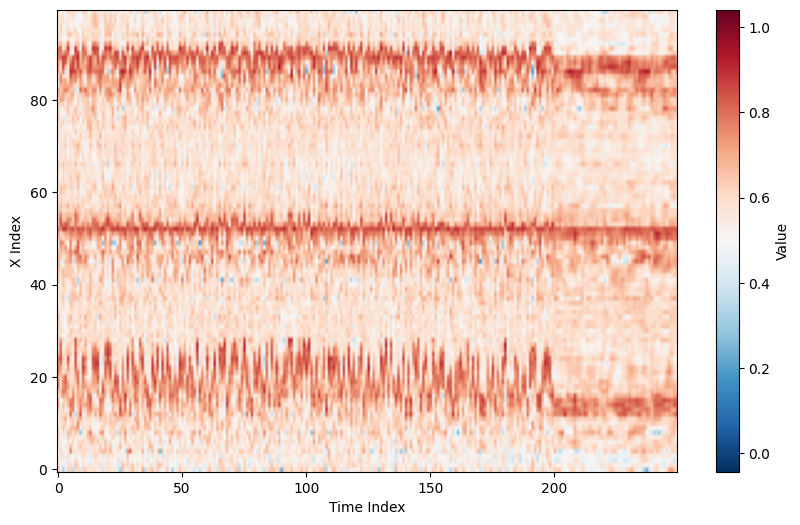

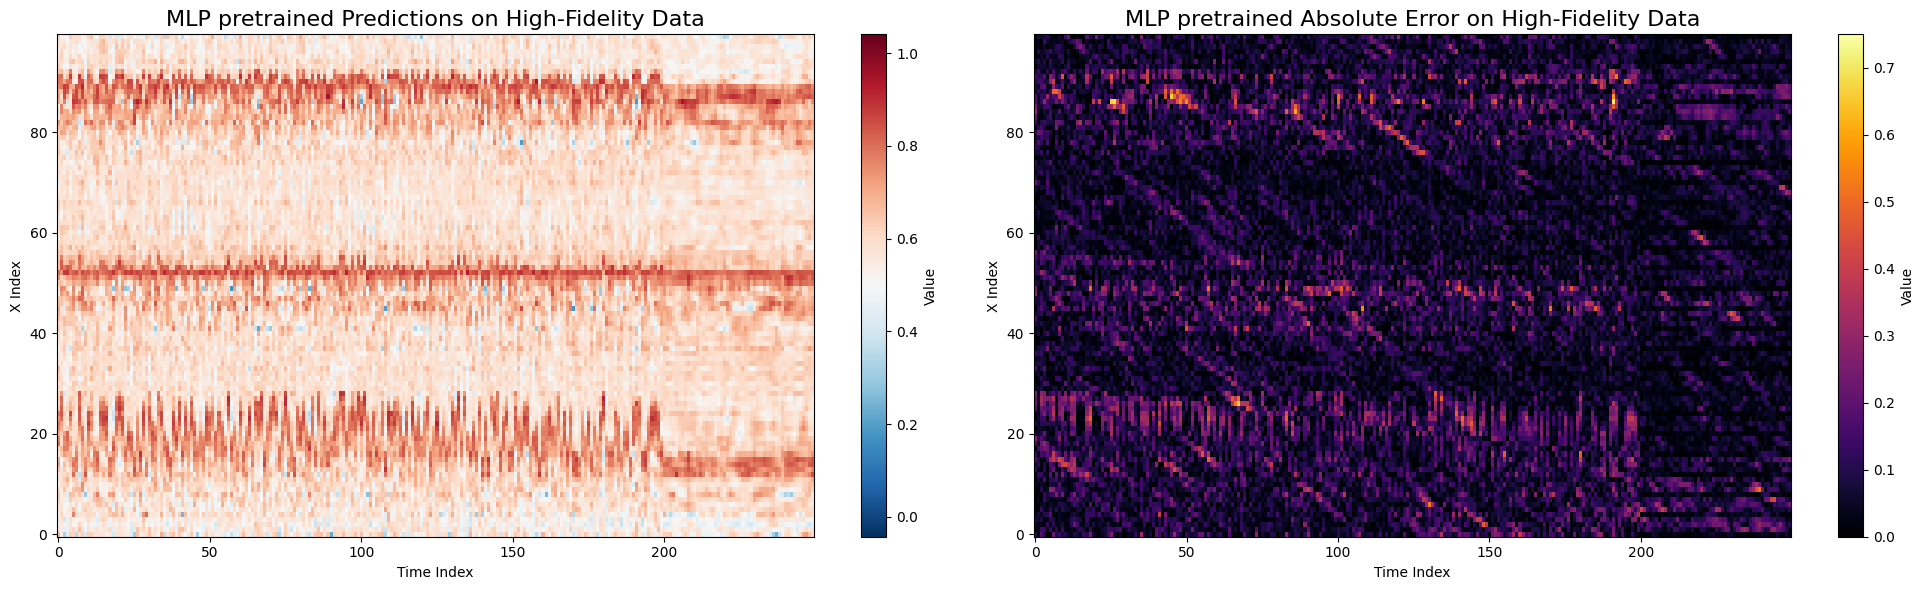

In [100]:

all_preds = np.concatenate([train_preds, preds], axis=0)
plot_1d_dataset_as_heatmap(all_preds, title="MLP Predictions on High-Fidelity Data")
inspect_model_predictions(data_model_1, all_preds, "MLP pretrained")

In [101]:
data_range = data_model_1.max() - data_model_1.min()

ssim_val = ssim(data_model_1, all_preds, data_range=data_range)
print(f"SSIM between MLP  (pretrained) predictions and high-fidelity data: {ssim_val:.6f}")



SSIM between MLP  (pretrained) predictions and high-fidelity data: 0.235350
